In [ ]:
# Copyright (c) 2025 Advanced Micro Devices, Inc. All rights reserved This software is distributed under the MIT License, Contact: Alessandro Fanfarillo

In [1]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from scipy.stats import anderson_ksamp, ks_2samp, gaussian_kde, mannwhitneyu, entropy
import seaborn as sns

torch.set_num_threads(16)

In [2]:
def simulate_max_temperature(month: int, day: int) -> float:
    # Check if the input is valid
    if month < 1 or month > 12:
        raise ValueError("Invalid month. Please enter a month between 1 and 12.")
    if day < 1 or day > 31:
        raise ValueError("Invalid day. Please enter a day between 1 and 31.")
    
    # Month and day pairs validation (e.g., February can't have 30 days)
    month_days = {
        1: 31, 2: 28, 3: 31, 4: 30, 5: 31, 6: 30,
        7: 31, 8: 31, 9: 30, 10: 31, 11: 30, 12: 31
    }
    
    if day > month_days[month]:
        raise ValueError(f"Invalid day for month {month}. {month} only has {month_days[month]} days.")

    # Simulate the day of the year
    days_in_year = 365
    day_of_year = sum(month_days[m] for m in range(1, month)) + day - 1
    
    # Simulate max temperature based on a sine wave for seasonal changes
    # Assuming the peak temperature in July and the lowest in January.
    max_temp = 60 + 40 * np.sin(2 * np.pi * (day_of_year / days_in_year - 0.2))
    
    # Add randomness for daily variation (e.g., between -10 and +10 degrees)
    random_variation = random.gauss(0, 5)
    
    max_temp = max_temp + random_variation
    
#    outlier_probability = 0.005
    
#    if random.random() < outlier_probability:
    # Generate an outlier: either extremely cold or extremely hot
#        if random.random() < 0.5:
            # Extremely cold outlier
#            max_temp += random.uniform(-20, -10)  # Below freezing outlier
#        else:
            # Extremely hot outlier
#            max_temp += random.uniform(10, 20)  # Unusually hot outlier
    
    return round(max_temp, 2)

In [3]:
# Example usage:
month = 7  # July
day = 15   # 15th day
temperature = simulate_max_temperature(month, day)
print(f"The simulated temperature in Denver on {month}/{day} is {temperature}°F.")

The simulated temperature in Denver on 7/15 is 98.88°F.


In [4]:
def generate_temperature_data(years: int = 10):
    month_days = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    max_temps = []
    month_day = []

    # Simulate data for each day over the specified number of years
    for year in range(years):
        for month in range(1, 13):
            for day in range(1, month_days[month - 1] + 1):
                temp = simulate_max_temperature(month, day)
                month_day_item = [month, day]
                max_temps.append(temp)
                month_day.append(month_day_item)
    
    max_temps_np = np.array(max_temps)
    month_day_np = np.array(month_day)
    
    return month_day_np, max_temps_np

# Generate 30 years of max temperature data
month_day_np, max_temps_np = generate_temperature_data(100)
print(month_day_np.shape, max_temps_np.shape)

(36500, 2) (36500,)


(100,)


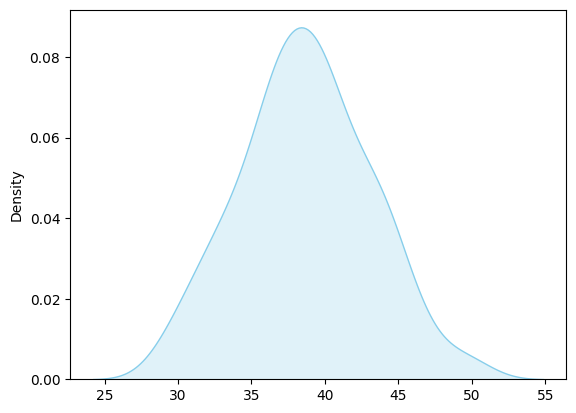

In [5]:
# Plot the distribution
feb_10_temp = max_temps_np[np.where((month_day_np[:,0]==2) & (month_day_np[:,1]==10))]
print(feb_10_temp.shape)
sns.kdeplot(feb_10_temp, fill=True, color="skyblue")
plt.show()

In [6]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
x = scaler_x.fit_transform(month_day_np)
y = scaler_y.fit_transform(max_temps_np.reshape(-1,1))

train_size = int(0.9 * len(x))
X_train, X_test = x[:train_size], x[train_size:]
Y_train, Y_test = y[:train_size], y[train_size:]

In [7]:
class CustomDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.from_numpy(X).float()
        self.Y = torch.from_numpy(Y).float()
        
    def __len__(self):
        return len(self.Y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

# Create datasets
train_dataset = CustomDataset(X_train, Y_train)
test_dataset = CustomDataset(X_test, Y_test)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

# Generative model: CVAE

In [8]:
class Encoder(nn.Module):
    def __init__(self, input_dim=3, latent_dim=2, hidden_dims=[32, 32]):
        super(Encoder, self).__init__()
        self.layers = nn.ModuleList()
        last_dim = input_dim
        # Create hidden layers with ReLU activations
        for h_dim in hidden_dims:
            self.layers.append(nn.Linear(last_dim, h_dim))
            last_dim = h_dim
        # Output layers for mean and log variance
        self.fc_mu = nn.Linear(last_dim, latent_dim)
        self.fc_logvar = nn.Linear(last_dim, latent_dim)
            
    def forward(self, x):
        """
        x: Concatenation of condition vector and target (batch_size, input_dim)
        Returns:
            mu: Mean of the latent variables
            logvar: Log variance of the latent variables
        """
        for layer in self.layers:
            x = F.relu(layer(x))
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

In [9]:
class Decoder(nn.Module):
    def __init__(self, latent_dim=2, condition_dim=2, hidden_dims=[32, 32]):
        super(Decoder, self).__init__()
        self.layers = nn.ModuleList()
        input_dim = latent_dim + condition_dim
        last_dim = input_dim
        # Create hidden layers with ReLU activations
        for h_dim in hidden_dims:
            self.layers.append(nn.Linear(last_dim, h_dim))
            last_dim = h_dim
        # Output layer for reconstructed target
        self.fc_out = nn.Linear(last_dim, 1)
            
    def forward(self, z, c):
        """
        z: Latent variables (batch_size, latent_dim)
        c: Condition vector (batch_size, condition_dim)
        Returns:
            y_recon: Reconstructed target variable
        """
        x = torch.cat([z, c], dim=1)
        for layer in self.layers:
            x = F.relu(layer(x))
        y_recon = self.fc_out(x)
        return y_recon

In [10]:
class CVAE(nn.Module):
    def __init__(self, input_dim=3, condition_dim=2, latent_dim=2, hidden_dims=[32,32]):
        super(CVAE, self).__init__()
        self.encoder = Encoder(input_dim=input_dim, latent_dim=latent_dim, hidden_dims=hidden_dims)
        self.decoder = Decoder(latent_dim=latent_dim, condition_dim=condition_dim, hidden_dims=hidden_dims)
        
    def reparameterize(self, mu, logvar):
        """
        Reparameterization trick to sample from N(mu, var) from N(0,1).
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)  # Random normal noise

        z = mu + eps * std
        return z
        
    def forward(self, x, y):

        # Concatenate condition vector and target variable
        xy = torch.cat([x, y], dim=1)
        mu, logvar = self.encoder(xy)
        z = self.reparameterize(mu, logvar)
        y_recon = self.decoder(z, x)  # Use condition vector in decoder
        return y_recon, mu, logvar

In [11]:
import math
def gaussian_likelihood_cvae_loss(y_mean, y_logvar, y, mu, logvar, beta=1.0):

    # 1) Negative log-likelihood of y under Gaussian(y_mean, exp(y_logvar)):
    #    0.5 * (log(2*pi) + y_logvar + (y - y_mean)^2 / exp(y_logvar))
    nll_element = 0.5 * (
        math.log(2.0 * math.pi)
        + y_logvar
        + (y - y_mean).pow(2) / (y_logvar.exp() + 1e-8)
    )
    recon_loss = torch.sum(nll_element)  # sum or mean, your choice
    
    # 2) KL divergence for z:
    #    KL = -0.5 * sum(1 + logvar - mu^2 - exp(logvar))
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    total_loss = recon_loss + beta * kl_loss
    return total_loss, recon_loss, kl_loss

def cyclic_kl_weight(epoch, cycle_length=50, ramp_length=25):

    # position within the current cycle
    cycle_pos = (epoch - 1) % cycle_length  # 0-based position in the cycle
    
    if cycle_pos < ramp_length:
        # linearly ramp up from 0 -> 1
        return float(cycle_pos) / float(ramp_length)
    else:
        # hold at 1
        return 1.0

def sigmoid_rampup(current, rampup_length):

    if rampup_length == 0:
        return 1.0
    else:
        current = float(current)
        phase = 1.0 - current / rampup_length
        return float(math.exp(-5.0 * phase * phase))

def cyclic_kl_weight_sigmoid(epoch, cycle_length=50, ramp_length=25):
    cycle_pos = (epoch - 1) % cycle_length
    if cycle_pos <= ramp_length:
        return sigmoid_rampup(cycle_pos, ramp_length)
    else:
        return 1.0

def loss_function(y_recon, y, mu, logvar, beta=1.1):

    # Reconstruction loss (MSE)
    recon_loss = F.mse_loss(y_recon, y, reduction='sum')
    # KL divergence
    KL = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    # Total loss normalized over the batch
    total_loss = (recon_loss + beta * KL) / y.size(0)
    return total_loss

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize model
model_cvae = CVAE(input_dim=3, condition_dim=2, latent_dim=50, hidden_dims=[512,512,512,512]).to(device)

# Optimizer
optimizer = optim.Adam(model_cvae.parameters(), lr=1e-4)

In [13]:
num_epochs = 120
beta = 0.1
for epoch in range(1, num_epochs + 1):
    model_cvae.train()
    train_loss = 0
    beta = cyclic_kl_weight(epoch)
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device)     # Condition vector X (batch_size, 2)
        target = target.to(device) # Target variable Y (batch_size, 1)
        optimizer.zero_grad()
        y_recon, mu, logvar = model_cvae(data, target)
        loss = loss_function(y_recon, target, mu, logvar, beta)
        loss.backward()
        train_loss += loss.item() * data.size(0)  # Multiply by batch size
        optimizer.step()
    avg_train_loss = train_loss / len(train_loader.dataset)
    if(epoch % 10 == 0):
        print('Epoch {}: Average loss: {:.6f}'.format(epoch, avg_train_loss))

Epoch 10: Average loss: 0.060819
Epoch 20: Average loss: 0.031128
Epoch 30: Average loss: 0.006811
Epoch 40: Average loss: 0.005350
Epoch 50: Average loss: 0.004815
Epoch 60: Average loss: 0.004372
Epoch 70: Average loss: 0.003966
Epoch 80: Average loss: 0.003857
Epoch 90: Average loss: 0.003618
Epoch 100: Average loss: 0.003556
Epoch 110: Average loss: 0.003339
Epoch 120: Average loss: 0.003243


In [14]:
from sklearn.metrics import mean_squared_error

def predict(model, x, num_samples=10, average=True):
    model.eval()
    x = x.to(device).float()
    y_preds = []
    with torch.no_grad():
        for _ in range(num_samples):
            z = torch.randn((x.size(0), model.encoder.fc_mu.out_features), dtype=torch.float32).to(device)
            y_pred = model.decoder(z, x)
            y_preds.append(y_pred)
        y_preds = torch.stack(y_preds)
        if(average == True):
            y_mean = torch.mean(y_preds, dim=0)
            ret = y_mean.cpu().numpy()
        else:
            ret = y_preds.cpu().numpy()
    return ret

x_test, y_test = test_dataset[:][0], test_dataset[:][1]

# Predict
y_pred = predict(model_cvae, x_test, num_samples=50)

# Compute RMSE
rmse = np.sqrt(mean_squared_error(y_test.numpy(), y_pred))
print('Test RMSE: {:.6f}'.format(rmse))

# Example new data point
new_X = scaler_x.transform(np.array([[2.0, 10.0]], dtype=np.float32))
new_X_tensor = torch.from_numpy(new_X).float()

# Predict
new_Y_pred = predict(model_cvae, new_X_tensor, num_samples=50)
print('Predicted Y:', np.round(scaler_y.inverse_transform(new_Y_pred[0][0].reshape(-1,1)),2), 'Real value', simulate_max_temperature(2, 10))

Test RMSE: 0.043643
Predicted Y: [[37.67]] Real value 38.52


In [15]:
def compute_kl_divergence(y,y_hat):
    kde1 = gaussian_kde(y)
    kde2 = gaussian_kde(y_hat)

    # Choose a grid to evaluate each KDE
    data_min = min(y.min(), y_hat.min())
    data_max = max(y.max(), y_hat.max())

    # We'll generate a grid of 200 points between data_min and data_max.
    x_grid = np.linspace(data_min, data_max, 500)

    #Evaluate the KDEs on this grid
    p_density = kde1(x_grid)  # unnormalized density from arr1
    q_density = kde2(x_grid)  # unnormalized density from arr2

    # Convert densities to discrete probabilities
    # We'll treat each point in x_grid as a "bin center" and approximate bin width as the spacing.
    dx = x_grid[1] - x_grid[0]
    p_probs = p_density / np.sum(p_density)  # sum would be ~1/dx, but let's normalize anyway
    q_probs = q_density / np.sum(q_density)

    # Multiply by dx to turn densities into a proper discrete approximation of total=1.
    p_probs *= dx
    q_probs *= dx

    # Compute KL divergences
    kl_pq = entropy(p_probs, q_probs)
    kl_qp = entropy(q_probs, p_probs)

    print("\nKDE-based approximation")
    print("-----------------------")
    print(f"KL(p || q) = {kl_pq:.6f}")
    print(f"KL(q || p) = {kl_qp:.6f}")

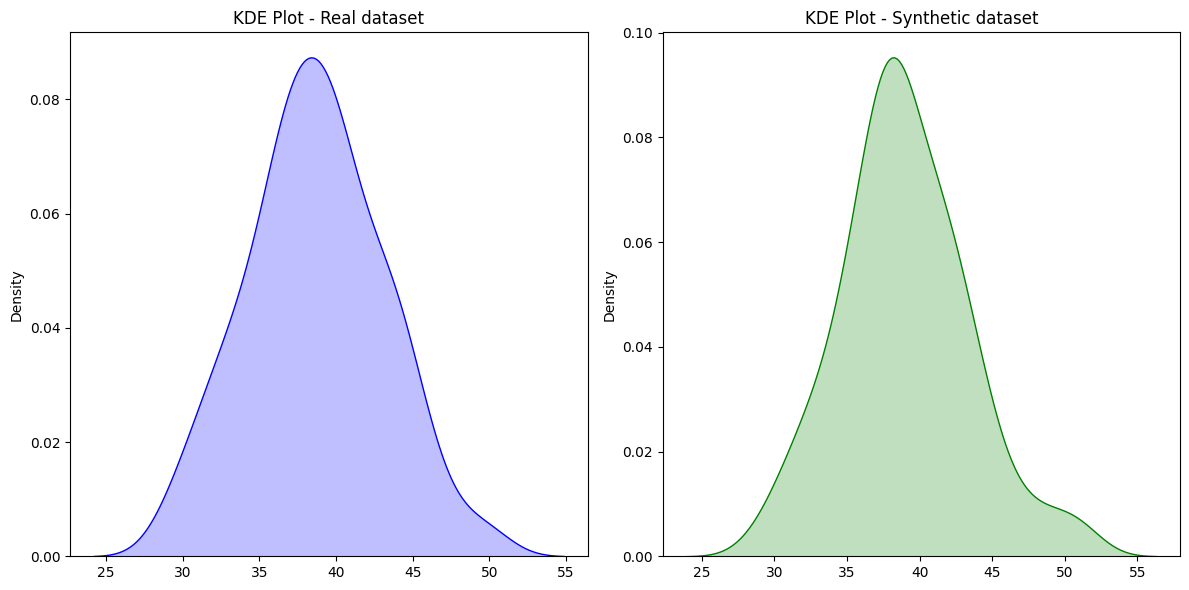

Real dataset mean and std: 38.6719 4.3532520476076275
Synthetic dataset mean and std: 38.9592 4.3217235
KS Statistic: 0.09, P-value: 0.8154147124661313
Mann-Whitney U Statistic: 4885.0, P-value: 0.7796548388443504
Anderson-Darling Statistic: -0.9601446072950646, P-value: 0.25

KDE-based approximation
-----------------------
KL(p || q) = 0.006961
KL(q || p) = 0.006956
[37.75 44.42 44.38 44.54 44.16 36.45 41.72 33.47 43.   40.24 40.77 34.57
 39.16 38.39 32.37 39.7  41.15 37.53 46.7  35.96 37.1  38.47 36.85 40.18
 41.01 38.52 31.56 45.73 29.78 39.74 36.64 43.61 33.52 40.3  40.47 36.12
 32.35 43.87 37.8  35.66 34.92 38.18 39.16 29.75 42.03 36.6  35.89 33.21
 41.23 32.76 44.92 36.12 29.41 37.36 35.95 32.81 40.48 43.25 41.74 43.37
 35.62 40.94 49.65 42.71 39.94 37.6  39.75 40.14 44.8  39.44 39.71 43.18
 36.16 38.22 36.92 38.61 43.38 38.38 42.94 47.01 31.33 49.65 39.31 33.8
 37.5  40.35 35.42 42.78 37.29 35.83 37.55 34.27 34.56 30.87 39.26 38.14
 31.53 45.71 33.58 38.51]
[44.11 34.45 35.46 39

/tmp/ipykernel_5750/3207695541.py:26: UserWarning: p-value capped: true value larger than 0.25. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  result = anderson_ksamp([feb_10_temp, y_pred])


In [25]:
# Compare the distribution
new_X = scaler_x.transform(np.array([[2.0, 10.0]], dtype=np.float32))
new_X_tensor = torch.from_numpy(new_X).float()
y_pred = predict(model_cvae, new_X_tensor, 100, False)
y_pred = np.round(scaler_y.inverse_transform(y_pred.reshape(-1,1)),2)
y_pred = y_pred[:,0]
#print("Expected Frequencies (under null hypothesis):")
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.kdeplot(feb_10_temp, ax=axes[0], fill=True, color="blue")
#sns.histplot(feb_10_temp, ax=axes[0], kde=False, edgecolor='black')
axes[0].set_title('KDE Plot - Real dataset')
sns.kdeplot(y_pred, ax=axes[1], fill=True, color="green")
#sns.histplot(y_pred, ax=axes[1], kde=False, edgecolor='green')
axes[1].set_title('KDE Plot - Synthetic dataset')
# Display the plots
plt.ylim(0, max(plt.gca().get_ylim()))
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

print("Real dataset mean and std:",np.mean(feb_10_temp),np.std(feb_10_temp))
print("Synthetic dataset mean and std:",np.mean(y_pred),np.std(y_pred))
stat, p_value = ks_2samp(feb_10_temp, y_pred)
print(f"KS Statistic: {stat}, P-value: {p_value}")
stat, p_value = mannwhitneyu(feb_10_temp, y_pred, alternative='two-sided')
print(f"Mann-Whitney U Statistic: {stat}, P-value: {p_value}")
result = anderson_ksamp([feb_10_temp, y_pred])
print(f"Anderson-Darling Statistic: {result.statistic}, P-value: {result.significance_level}")
compute_kl_divergence(feb_10_temp,y_pred)
print(feb_10_temp)
print(y_pred)

# Discriminative model: DNN

In [17]:
class RegressionDNN(nn.Module):
    def __init__(self, input_dim=2, output_dim=1, hidden_dims=[32, 32]):
        super(RegressionDNN, self).__init__()
        layers = []
        last_dim = input_dim
        # Create hidden layers
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(last_dim, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.2))
            last_dim = hidden_dim
        # Output layer
        layers.append(nn.Linear(last_dim, output_dim))
        self.network = nn.Sequential(*layers)
        
    def forward(self, x):
        """
        x: Input tensor of shape (batch_size, input_dim)
        Returns:
            Output tensor of shape (batch_size, output_dim)
        """
        return self.network(x)

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize model
model_dnn = RegressionDNN(input_dim=2, output_dim=1, hidden_dims=[32, 32, 32]).to(device)

# Define loss function
criterion = nn.MSELoss()

# Optimizer
optimizer = optim.Adam(model_dnn.parameters(), lr=1e-4)

In [19]:
num_epochs = 350

for epoch in range(1, num_epochs + 1):
    model_dnn.train()
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).float()
        target = target.to(device).float()
        optimizer.zero_grad()
        outputs = model_dnn(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)
    avg_train_loss = train_loss / len(train_loader.dataset)
    if (epoch % 10 == 0):
        print('Epoch {}: Average loss: {:.6f}'.format(epoch, avg_train_loss))

Epoch 10: Average loss: 0.056958
Epoch 20: Average loss: 0.032056
Epoch 30: Average loss: 0.020244
Epoch 40: Average loss: 0.015769
Epoch 50: Average loss: 0.013669
Epoch 60: Average loss: 0.012021
Epoch 70: Average loss: 0.011150
Epoch 80: Average loss: 0.010336
Epoch 90: Average loss: 0.009906
Epoch 100: Average loss: 0.009280
Epoch 110: Average loss: 0.008950
Epoch 120: Average loss: 0.008601
Epoch 130: Average loss: 0.008018
Epoch 140: Average loss: 0.007776
Epoch 150: Average loss: 0.007309
Epoch 160: Average loss: 0.007107
Epoch 170: Average loss: 0.006820
Epoch 180: Average loss: 0.006476
Epoch 190: Average loss: 0.006479
Epoch 200: Average loss: 0.006129
Epoch 210: Average loss: 0.006051
Epoch 220: Average loss: 0.005753
Epoch 230: Average loss: 0.005579
Epoch 240: Average loss: 0.005462
Epoch 250: Average loss: 0.005358
Epoch 260: Average loss: 0.005317
Epoch 270: Average loss: 0.005122
Epoch 280: Average loss: 0.005130
Epoch 290: Average loss: 0.004991
Epoch 300: Average loss

In [20]:
model_dnn.eval()
with torch.no_grad():
    x_test = torch.from_numpy(X_test).float().to(device)
    y_test = torch.from_numpy(Y_test).float().to(device)
    y_pred = model_dnn(x_test)
    y_pred_np = y_pred.cpu().numpy()
    y_test_np = y_test.cpu().numpy()
    rmse = np.sqrt(mean_squared_error(y_test_np, y_pred_np))
    print('Test RMSE: {:.6f}'.format(rmse))

Test RMSE: 0.054330


In [21]:
def predict_dnn(model, x, num_samples=1, average=False):
    """
    Generates predictions for new data.
    Args:
        model: Trained DNN model
        x: Input tensor (batch_size, input_dim)
    Returns:
        y_pred: Predicted output tensor
    """
    #model.eval()
    model.train()
    x = x.to(device).float()
    y_pred = []
    with torch.no_grad():
        for i in range(num_samples):
            tmp = model(x)
            y_pred.append(tmp)
    y_pred = torch.stack(y_pred)
    if(average == True):
        y_mean = torch.mean(y_pred, dim=0)
        ret = y_mean.cpu().numpy()
    else:
        ret = y_pred.cpu().numpy()
    return ret

In [22]:
new_X = scaler_x.transform(np.array([[1.0, 2.0]], dtype=np.float32))
new_X_tensor = torch.from_numpy(new_X).float()

# Predict
new_Y_pred = predict_dnn(model_dnn, new_X_tensor, 50, True)
print('Predicted Y:', scaler_y.inverse_transform(new_Y_pred[0][0].reshape(-1,1)), simulate_max_temperature(1, 2))

Predicted Y: [[27.604612]] 31.42


Chi2 Stat: 9525.000000000002
P-Value: 0.19647159733717054
Degrees of Freedom: 9408
Expected Frequencies (under null hypothesis):


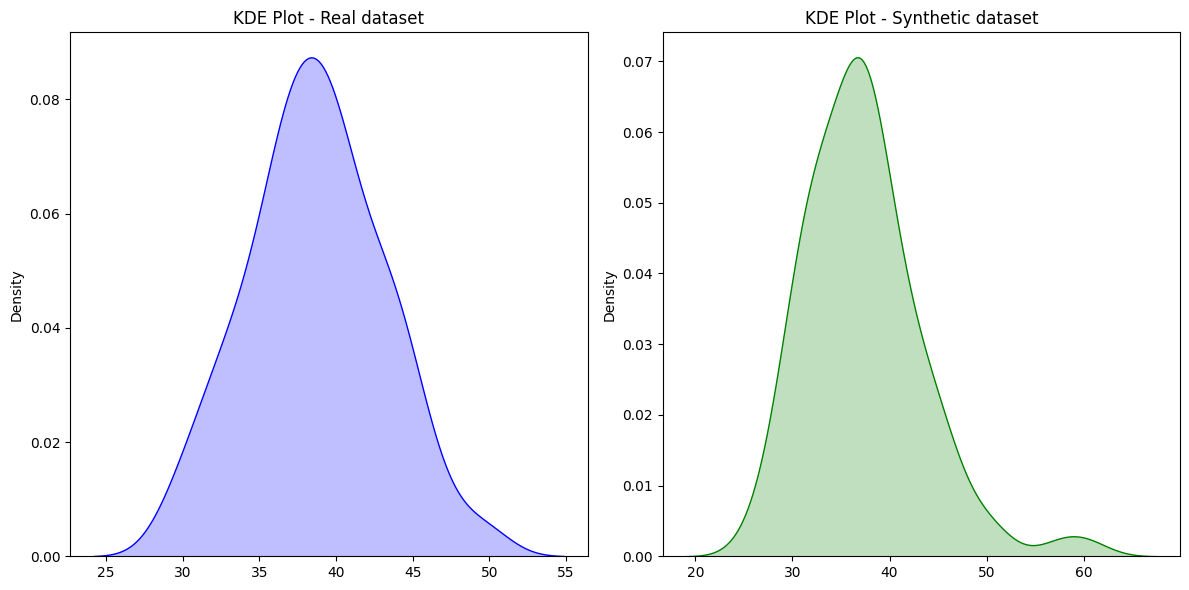

Real dataset mean and std: 38.6719 4.3532520476076275
Synthetic dataset mean and std: 37.278698 5.9262094
KS Statistic: 0.21, P-value: 0.024055802841094577
Mann-Whitney U Statistic: 6041.0, P-value: 0.011010986741693544
Anderson-Darling Statistic: 4.169604017219187, P-value: 0.006975919982565941

KDE-based approximation
-----------------------
KL(p || q) = 0.102637
KL(q || p) = 0.242322


In [23]:
# Compare the distribution
new_X = scaler_x.transform(np.array([[2.0, 10.0]], dtype=np.float32))
new_X_tensor = torch.from_numpy(new_X).float()
y_pred = predict_dnn(model_dnn, new_X_tensor, 100, False)
y_pred = scaler_y.inverse_transform(y_pred.reshape(-1,1))
y_pred = y_pred[:,0]
contingency_table = pd.crosstab(feb_10_temp, y_pred)
chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)
print(f"Chi2 Stat: {chi2_stat}")
print(f"P-Value: {p_val}")
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies (under null hypothesis):")
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.kdeplot(feb_10_temp, ax=axes[0], fill=True, color="blue")
axes[0].set_title('KDE Plot - Real dataset')
sns.kdeplot(y_pred, ax=axes[1], fill=True, color="green")
axes[1].set_title('KDE Plot - Synthetic dataset')
# Display the plots
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()
print("Real dataset mean and std:",np.mean(feb_10_temp),np.std(feb_10_temp))
print("Synthetic dataset mean and std:",np.mean(y_pred),np.std(y_pred))
stat, p_value = ks_2samp(feb_10_temp, y_pred)
print(f"KS Statistic: {stat}, P-value: {p_value}")
stat, p_value = mannwhitneyu(feb_10_temp, y_pred, alternative='two-sided')
print(f"Mann-Whitney U Statistic: {stat}, P-value: {p_value}")
result = anderson_ksamp([feb_10_temp, y_pred])
print(f"Anderson-Darling Statistic: {result.statistic}, P-value: {result.significance_level}")
compute_kl_divergence(feb_10_temp,y_pred)